In [31]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [32]:
# !unzip -qq '/content/drive/MyDrive/Colab Notebooks/demo/archive.zip' -d '/content/drive/MyDrive/Colab Notebooks/demo/archive'

In [33]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets

In [34]:
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')
print('Using PyTorch version:', torch.__version__, ' Device:', DEVICE)

Using PyTorch version: 1.13.1+cu116  Device: cuda


In [35]:
BATCH_SIZE = 64
EPOCHS = 100

In [36]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(384),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ]),
    'val': transforms.Compose([
        transforms.CenterCrop(384),
        transforms.Resize(384),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ]),
}

image_datasets = {x: datasets.ImageFolder("/content/drive/MyDrive/Colab Notebooks/demo/archive/hymenoptera_data", data_transforms[x]) for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size = BATCH_SIZE, num_workers = 0, shuffle = True) for x in ['train', 'val']}

In [37]:
for (X_train, y_train) in dataloaders['train']:
    print('X_train:', X_train.size(), 'type:', X_train.type())
    print('y_train:', y_train.size(), 'type:', y_train.type())
    break

X_train: torch.Size([64, 3, 384, 384]) type: torch.FloatTensor
y_train: torch.Size([64]) type: torch.LongTensor


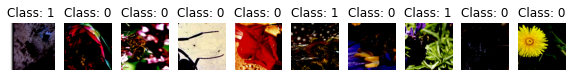

In [38]:
pltsize = 1
plt.figure(figsize=(10 * pltsize, pltsize))

for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.axis('off')
    plt.imshow(np.transpose(X_train[i], (1, 2, 0)))
    plt.title('Class: ' + str(y_train[i].item()))

In [39]:
def train(model, train_loader, optimizer, log_interval):
    model.train()
    for batch_idx, (image, label) in enumerate(train_loader):
        image = image.to(DEVICE, dtype=torch.float)
        label = label.to(DEVICE, dtype=torch.float)
        optimizer.zero_grad()
        output = model(image).squeeze(dim=1)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()

        if batch_idx % log_interval == 0:
            print("Train Epoch: {} [{}/{} ({:.0f}%)]\tTrain Loss: {:.6f}".format(
                epoch, batch_idx * len(image), 
                len(train_loader.dataset), 100. * batch_idx / len(train_loader), 
                loss.item()))

In [40]:
def evaluate(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for image, label in test_loader:
            image = image.to(DEVICE, dtype=torch.float)
            label = label.to(DEVICE, dtype=torch.float)
            output = model(image).squeeze(dim=1)
            output1 = output.cpu()
            output1[output1 >= 0.5] = 1
            output1[output1 < 0.5] = 0
            test_loss += criterion(output, label).item()
            correct += output1.eq(label.cpu()).int().sum()
    
    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, test_accuracy

In [41]:
'''
import torchvision.models as models
model = models.resnet18(pretrained = False).cuda()
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)
model = model.cuda()
'''

'\nimport torchvision.models as models\nmodel = models.resnet18(pretrained = False).cuda()\nnum_ftrs = model.fc.in_features\nmodel.fc = nn.Linear(num_ftrs, 2)\nmodel = model.cuda()\n'

In [42]:
# !pip install timm

In [43]:
import timm

model = timm.create_model('vit_large_patch32_384', pretrained=True).cuda()

for parameter in model.parameters():
    parameter.requires_grad = False

num_features = model.head.in_features

model.head = nn.Sequential(
    nn.Linear(num_features, 1),
    nn.Sigmoid()
)

model = model.cuda()

In [44]:
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
criterion = nn.BCELoss()

print(model)

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 1024, kernel_size=(32, 32), stride=(32, 32))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=1024, out_features=3072, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=1024, out_features=1024, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=1024, out_features=4096, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (fc2): Linear(in_features=4096, out_features=1024, bias=True)
        (drop2): Dropout(p=0.0, i

In [45]:
for epoch in range(1, EPOCHS + 1):
    train(model, dataloaders["train"], optimizer, log_interval = 5)
    valid_loss, valid_accuracy = evaluate(model, dataloaders["val"])
    print("\n[EPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} % \n".format(
        epoch, valid_loss, valid_accuracy))

Train Epoch: 1 [0/397 (0%)]	Train Loss: 0.733652
Train Epoch: 1 [320/397 (71%)]	Train Loss: 0.695976

[EPOCH: 1], 	Test Loss: 0.0121, 	Test Accuracy: 61.21 % 

Train Epoch: 2 [0/397 (0%)]	Train Loss: 0.693398
Train Epoch: 2 [320/397 (71%)]	Train Loss: 0.752107

[EPOCH: 2], 	Test Loss: 0.0111, 	Test Accuracy: 62.97 % 

Train Epoch: 3 [0/397 (0%)]	Train Loss: 0.625809
Train Epoch: 3 [320/397 (71%)]	Train Loss: 0.631776

[EPOCH: 3], 	Test Loss: 0.0110, 	Test Accuracy: 65.24 % 

Train Epoch: 4 [0/397 (0%)]	Train Loss: 0.629688
Train Epoch: 4 [320/397 (71%)]	Train Loss: 0.587630

[EPOCH: 4], 	Test Loss: 0.0108, 	Test Accuracy: 62.97 % 

Train Epoch: 5 [0/397 (0%)]	Train Loss: 0.679394
Train Epoch: 5 [320/397 (71%)]	Train Loss: 0.629699

[EPOCH: 5], 	Test Loss: 0.0112, 	Test Accuracy: 63.98 % 

Train Epoch: 6 [0/397 (0%)]	Train Loss: 0.514191
Train Epoch: 6 [320/397 (71%)]	Train Loss: 0.601238

[EPOCH: 6], 	Test Loss: 0.0107, 	Test Accuracy: 69.27 % 

Train Epoch: 7 [0/397 (0%)]	Train Loss: 